## Brute force : multinomial naive bayes on basic features
* Default parameters for multinomial naive bayes
* No cross validation, no hyper parameters
* train is done on unbalanced data (distribution of is_duplicate is no the same on train and challenge data)

*BUT* a bunch of features are tested
* Compute common_words between question1 & question2
* Compute Nb common_words between question1 & question2
* Compute Nb common words/nb words in question1
* Compute Nb common words/nb words in question2
* Compute Nb words in question1,question2 not in common words
* Compute (nb common words)/(nb words in question1+nb word in question2)
These features are combined to generate 255 models

# Sequence
* All features are generated
    * on training data
    * on challenge data (overkill as some features may be rejected later but easier)
* AUC graphs are computed for each single feature, so we can bet if it is potentially useful
* Models are trained on *ALL* combination of features
    * on a a partition 80/20
    * on full training data 
* Performances of all models are saved in a excel file
    * logloss on proba (test+full)
    * logloss on decision (test+full)
    * accuracy (test+full)
    * score (weighted combination of f1-score) (test+full)
* Various requests on performances database are done
* Apply is done on best 3 models (test & full)
    * proba is generated in a csv
    * csv is zipped
    * command line to publish in kaggle is displayed (no automatic submission to keep control)
* Kaggle performances are downloaded and saved
* Varipus requests on kaggle performances are done


## Some setup and os tools

In [26]:
import numpy
import pandas
import os
import matplotlib.pyplot as plot
import seaborn as sns
from shutil import copyfile
from IPython.display import IFrame, display, HTML
%matplotlib inline

# This is supposed to enhance default pandas display
pandas.set_option('display.width',200)
pandas.set_option('display.max_colwidth',200)

# the folder where this experiment will be stored
EXPERIMENT = 'multinomial_naivebayes_unbalanced'

# The name of the docker image (used to display docker command to copy apply files to windows host)
DOCKER_IMAGE_NAME = 'dev_ds_1'

# Some common resources
PANDAS_STORE = '../PandasStore'
KAGGLE_EXE = '/root/anaconda3/bin/kaggle'
PICKLE_EXTENSION = '.pkl'
CLEAN_TRAINING_DATA = 'clean_training'
CLEAN_CHALLENGE_DATA = 'clean_challenge'

# Other useful constants
ZIP_EXTENSION = '.zip'
SEP_IN_FILE_NAME = '!'
KAGGLE_GET_SUBMISSIONS_COMMAND = KAGGLE_EXE +' competitions submissions quora-question-pairs --csv'
EXCEL_PRECISION='%.6f'

# Try to have a minimal decoration in notebook output
def print_html(s):
    display(HTML(s, metadata=dict(isolated=True)))

def start_small():
    display(HTML('<span><small>', metadata=dict(isolated=True)))

def print_small(s):
    print_html('<small>',s,'</small>')

def end_small():
    display(HTML('</small></span>', metadata=dict(isolated=True)))

def start_italic():
    display(HTML('<i>', metadata=dict(isolated=True)))

def print_italic(s):
    print_html('<i>'+s+'</i>')

def end_italic():
    display(HTML('</i>', metadata=dict(isolated=True)))

def start_bold():
    display(HTML('<b>', metadata=dict(isolated=True)))

def print_bold(s):
    print_html('<b>'+s+'</b>')

def end_bold():
    display(HTML('</b>', metadata=dict(isolated=True)))

def print_bullet(s):
    print_html('<li>'+s)

def print_section(s):
    print_bold(s)
    print_html('<HR>')

def print_done(s):
    print_html('<span style="color:LIMEGREEN"><small><b><i>'+s+'</i></b><p></p></small></span>')

def print_info(s):
    print_html('<span style="color:LIMEGREEN"><small>'+s+'</small></span>')

def print_warning(s):
    print_html('<span style="color:LIGHTSALMON"><small>'+s+'</small></span>')

## Plenty of small tools to help not creating a huge mess

def global_pandas_store_file_name(file_name,ext='.pkl'):
    return PANDAS_STORE +'/'+file_name+ext

def local_pandas_store_file_name(file_name):
    return env_file_name(file_name,PICKLE_EXTENSION)

def env_path():
    return '../'+EXPERIMENT

def env_file_name(file_name,ext=''):
    return env_path()+'/'+file_name+ext

def absolute_env_file_name(file_name,ext=''):
    return str(os.path.abspath(env_path()+'/'+file_name+ext))

def copy_from_pandas_store_if_missing(file_name):
    if not os.path.exists(env_file_name(file_name)):
        print_info('Make local copy of %s' % global_pandas_store_file_name(file_name))
        copyfile(global_pandas_store_file_name(file_name),local_pandas_store_file_name(file_name))

def prepare_environnement():
    print_section('Prepare %s environment' % EXPERIMENT)
    if not os.path.exists(env_path()):
        os.mkdir(env_path())
    copy_from_pandas_store_if_missing(CLEAN_TRAINING_DATA)
    copy_from_pandas_store_if_missing(CLEAN_CHALLENGE_DATA)
    print_done('Done')
    print

## Tools to cache important and costly data

def load_dataframe(file_name):
    df = pandas.read_pickle(local_pandas_store_file_name(file_name))
    return df

def save_dataframe(df,file_name):
    print_info('Save %s' % file_name )
    df.to_pickle(local_pandas_store_file_name(file_name))

def load_or_build_dataframe(dataframe_name,file_name,builder,dataframe):
    print_section('%s: Load or rebuild %s' % (dataframe_name,file_name))
    if os.path.exists(local_pandas_store_file_name(file_name)):
        print_info("!!!!! %s is cached!!!" % local_pandas_store_file_name(file_name))
        df = load_dataframe(file_name)
    else:
        print_warning("!!!!! %s does not exists!!!" % local_pandas_store_file_name(file_name))
        print_warning('Rebuild and save it')
        df = builder(dataframe)
        save_dataframe(df,file_name)
    print_done('Done:%s contains %d lines' % (file_name,len(df)))
    return df

# Code to generate all combination of numeric features
from itertools import compress, product
from itertools import chain, combinations

def all_numeric_columns(dataframe):
    l = list()
    for name in dataframe.columns:
        if dataframe.dtypes[name] in ['int64','float64'] and name not in ['test_id','id','qid1','qid2','is_duplicate']:
            l.append( name)
    return l

def all_subsets(ss):
    return list(chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1))))

def clean_combination_name(c):
    return str(numpy.asarray(c)).replace("' '","+").replace("['","").replace("']","").replace("'","").replace(" ","").replace('\n','+')

def clean_all_combination_names(dataframe):
    for c in all_subsets(all_numeric_columns(dataframe)):
        if len(c)>0:
            print('|%s|'% clean_combination_name(c))

#print( 'All numeric columns\n%s' % all_numeric_columns(train_dataframe))
#print('All combinations of numeric columns\n %d combinations\n' % len(all_subsets(all_numeric_columns(train_dataframe))))
#for c in all_subsets(all_numeric_columns(train_dataframe)):
#    print(c)
#clean_all_combination_names(train_dataframe)
#print( '%d combination of features will be studied' % (len(list(all_subsets(all_numeric_columns(train_dataframe))))-1))

# code to put plots in a grid

def multiplot_from_generator(g, num_columns, figsize_for_one_row=None):
    # call 'next(g)' to get past the first 'yield'
    next(g)
    # default to 15-inch rows, with square subplots
    if figsize_for_one_row is None:
        figsize_for_one_row = (15, 15/num_columns)
    try:
        while True:
            # call plt.figure once per row
            plot.figure(figsize=figsize_for_one_row)
            for col in range(num_columns):
                ax = plot.subplot(1, num_columns, col+1)
                next(g)
    except StopIteration:
        pass

# apply tools
def apply_file_name(criteria,kind,model_key,ext='.csv'):
    return env_file_name(SEP_IN_FILE_NAME.join((EXPERIMENT,criteria,kind,clean_combination_name(model_key).replace('/','_div_'))),ext=ext)

def apply_absolute_file_name(criteria,kind,model_key,ext='.csv'):
    return str(os.path.abspath(apply_file_name(criteria,kind,model_key,ext=ext)))

# Zip tools
from zipfile import ZipFile,ZIP_DEFLATED 
import zlib
import os
from pathlib import Path

def zip_file_name(original_file_name):
    return str(Path(original_file_name).with_suffix('.zip'))

def zip_file_and_delete(original_file_name):
    zip_name = zip_file_name(original_file_name) 
    zip = ZipFile(str(zip_name), 'w',compression=ZIP_DEFLATED)
    zip.write(original_file_name)
    zip.close()
    os.unlink(original_file_name)
    return zip_name

# Excel tools
def excel_file_name(file_name):
    return env_file_name(file_name,ext='.xlsx')

def pandas_to_excel(dataframe,file_name):
    dataframe.to_excel(excel_file_name(SEP_IN_FILE_NAME.join([EXPERIMENT,file_name])),float_format=EXCEL_PRECISION)

def save_models_dict_to_excel(models_dict,file_name='all_models'):
    results = models_dict_to_models_results(models_dict)
    results.to_excel(excel_file_name('_'.join([EXPERIMENT,file_name])),float_format="%.4f")

# Kaggle submissions tool
import subprocess

def load_kaggle_submissions():
    print_section('Load all Kaggle submissions')
    generic_submissions_name = EXPERIMENT+'_submissions'
    file_name_csv = absolute_env_file_name(generic_submissions_name,ext='.csv')
    file_name_excel = absolute_env_file_name(excel_file_name(generic_submissions_name))
    csv_output = open(file_name_csv,"w")
    proc = subprocess.Popen(KAGGLE_GET_SUBMISSIONS_COMMAND.split(),stdout=csv_output)
    proc.wait()
    csv_output.close()
    print_info('All submissions are available in .csv&nbsp;&nbsp;format with %s' % file_name_csv)
    submissions = pandas.read_csv(file_name_csv,error_bad_lines=True,warn_bad_lines=True)
    # fix dataframe so it is more convenient to use
    #submissions = submissions[submissions['status']=='complete' & submissions['description']!='first xgboost']
    submissions = submissions[submissions['status']=='complete']
    submissions = submissions[['date','publicScore','privateScore','description','fileName']]
    submissions['date'] = pandas.to_datetime(submissions['date'])
    submissions['publicScore'] = submissions['publicScore'].astype('float64')
    submissions['privateScore'] = submissions['privateScore'].astype('float64')
    submissions.to_excel(file_name_excel,float_format="%.4f")
    print_info('All submissions are available in .xlsx format with %s' % file_name_excel)
    return submissions

def show_last_submissions(submissions,n=3):
    return submissions.nlargest(n,'date')

def put_first(l,e):
    l.insert(0,e)
    return list(dict.fromkeys(l))


def show_best_submissions(submissions,n=3,metric='publicScore',):
    return submissions.nsmallest(n,metric)[put_first(submissions.columns.values.tolist(),metric)]


In [2]:
## Build simple features

In [7]:

def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].apply(function)
    return dataframe[output_column_name]


def build_all_simple_features(dataframe):
    start_small()
    print_warning('Compute common_words between question1 & question2')
    add_column_from_column(dataframe,'nb_words_question1','question1',lambda x: len(x.split()))
    add_column_from_column(dataframe,'nb_words_question2','question2',lambda x: len(x.split()))
    print_warning('Compute Nb common_words between question1 & question2')
    add_column_from_columns(dataframe,'common_words',lambda r: list(set(r.question1.split())&set(r.question2.split())))
    add_column_from_column(dataframe,'nb_common_words','common_words',len)

    print_warning('Compute Nb common words/nb words in question1')
    add_column_from_columns(dataframe,'nb_common_words/nb_words_question1',lambda r: r.nb_common_words/max(1,r.nb_words_question1))
    print_warning('Compute Nb common words/nb words in question2')
    add_column_from_columns(dataframe,'nb_common_words/nb_words_question2',lambda r: r.nb_common_words/max(1,r.nb_words_question2))

    print_warning('Compute Nb words in question1,question2 not in common words')
    add_column_from_columns(dataframe,'nb_words_question1-common_words',lambda r: len(list(set(r.question1.split())-set(r.common_words))))
    add_column_from_columns(dataframe,'nb_words_question2-common_words',lambda r: len(list(set(r.question2.split())-set(r.common_words))))
    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_columns(dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)',lambda r: r.nb_common_words/(r.nb_words_question1+r.nb_words_question2))
    end_small()
    dataframe=dataframe.drop(columns='common_words')
    return dataframe

# First steps
* Train & Challenge: Read original data (minimal low level cleaning already done)
* Train & Challenge: Compute basic features
    * Compute common_words between question1 & question2
    * Compute Nb common_words between question1 & question2
    * Compute Nb common words/nb words in question1
    * Compute Nb common words/nb words in question2
    * Compute Nb words in question1,question2 not in common words
    * Compute (nb common words)/(nb words in question1+nb word in question2)


In [8]:
prepare_environnement()
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)

train_dataframe=load_or_build_dataframe('Training basic features','training_basic_features',build_all_simple_features,train_dataframe)
challenge_dataframe=load_or_build_dataframe('Challenge basic features','challenge_basic_features',build_all_simple_features,challenge_dataframe)

In [10]:
train_dataframe.head()

,id,qid1,qid2,question1,question2,is_duplicate,nb_words_question1,nb_words_question2,nb_common_words,nb_common_words/nb_words_question1,nb_common_words/nb_words_question2,nb_words_question1-common_words,nb_words_question2-common_words,nb_common_words/(nb_words_question1+nb_words_question2)
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,14,12,10,0.714286,0.833333,2,1,0.384615
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,8,13,4,0.500000,0.307692,4,8,0.190476
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,14,10,3,0.214286,0.300000,11,7,0.125000
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,11,9,0,0.000000,0.000000,10,9,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,13,7,2,0.153846,0.285714,11,5,0.100000


In [ ]:
challenge_dataframe.head()

Define some code to easily compute AUC of these basic features

In [9]:

from sklearn.metrics import roc_auc_score

def simple_AUC(dataframe,column_name):
    return roc_auc_score(dataframe['is_duplicate'],dataframe[column_name])

def show_AUC(dataframe,column_name):
    print_bullet('AUC %s: %f' % (column_name,simple_AUC(dataframe,column_name)))

def display_simple_AUC(dataframe,column_name):
    palette = sns.color_palette()
    # Let multiplot_generator figure the size
    #plot.figure(figsize=(10, 7))
    plot.hist(dataframe[column_name][dataframe['is_duplicate']==1],bins=50,color=palette[3],label='Same',histtype='step')
    plot.hist(train_dataframe[column_name][dataframe['is_duplicate']==0],bins=50,color=palette[2],label='Different',alpha = 0.75,histtype='step')
    plot.title('AUC %s : %f' % (column_name,simple_AUC(dataframe,column_name)) , fontsize=10)
    plot.xlabel(column_name)
    plot.ylabel('Nb')
    plot.legend()


def show_all_simple_AUC(dataframe):
    all =  all_numeric_columns(dataframe)
    print_section( 'Show AUC on %d unique features' % len(all))
    for name in all:
        show_AUC(dataframe,name)
        yield
        display_simple_AUC(dataframe,name)
    print_done('Done')


def show_all_simple_AUC_in_grid(dataframe,nb_columns=2):
    multiplot_from_generator(show_all_simple_AUC(dataframe), nb_columns)

## Is there a bit of information in our features ??

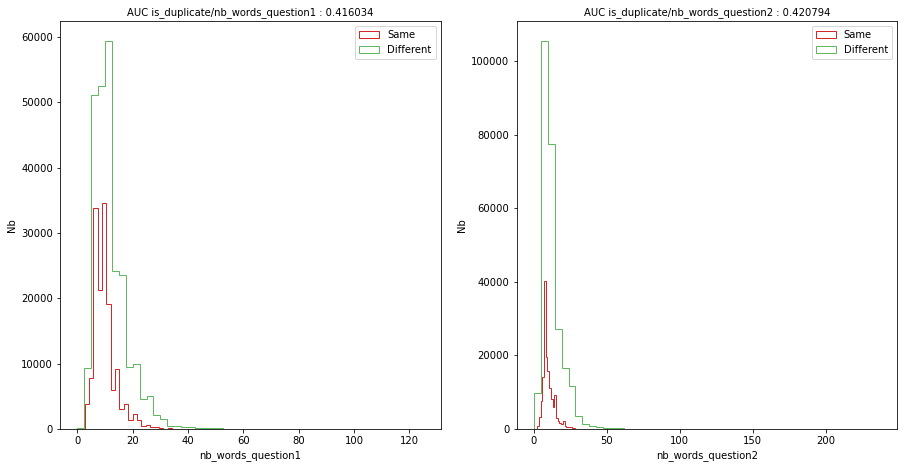

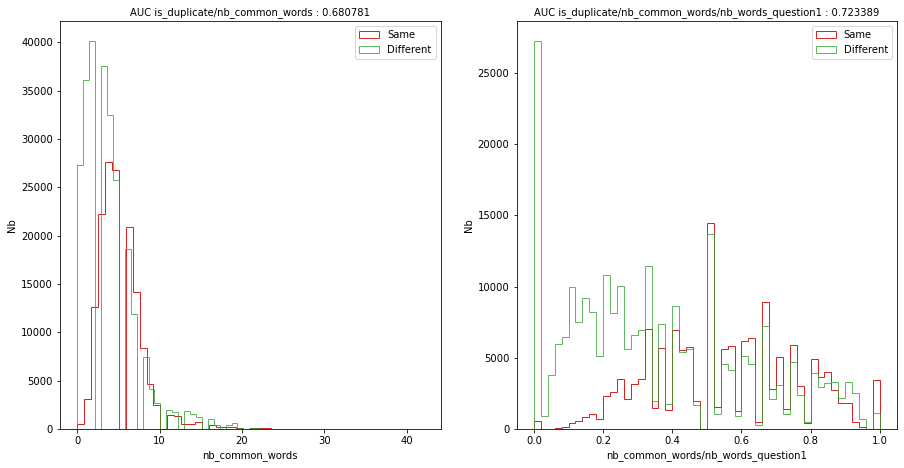

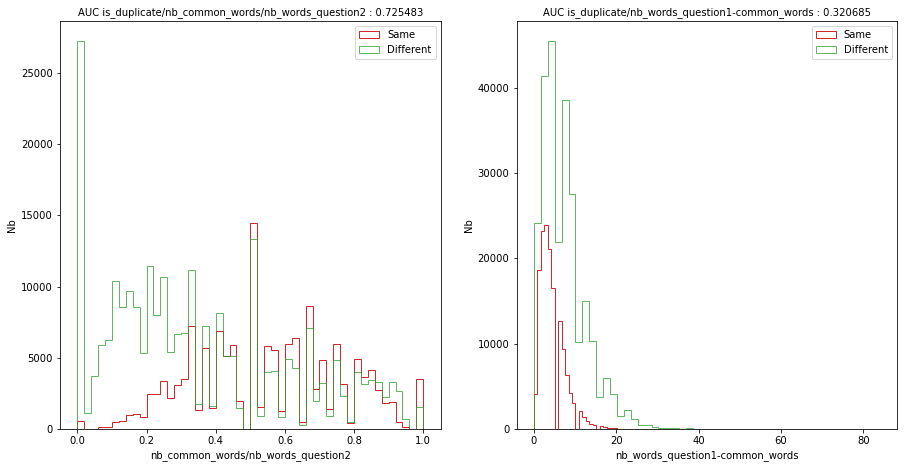

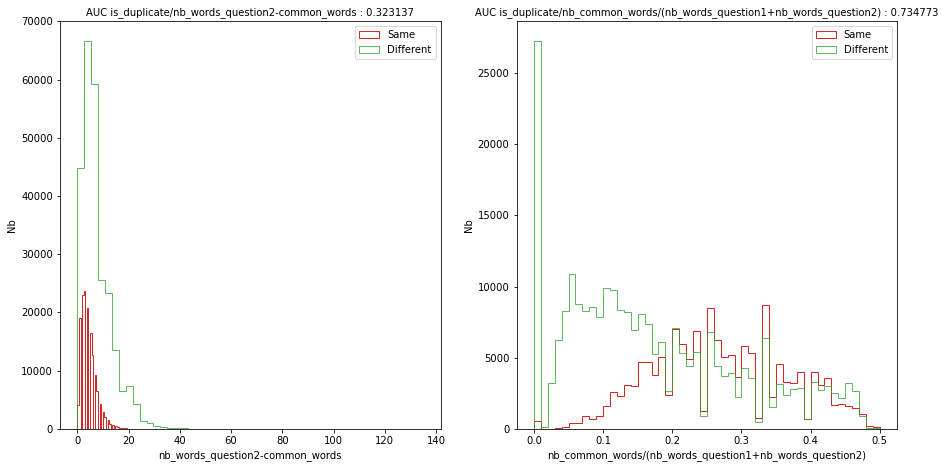

In [11]:
show_all_simple_AUC_in_grid(train_dataframe,nb_columns=2)

## Code to build simple naive bayes model on these features

In [240]:

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# This will add a suffix to all keys of a dict
# Used to add _test,_train,_full to keys of infos about a model

FAKE_INFOS_ON_MODEL_TEST_TRAIN = {
    'accuracy_train': 0,
    'score_train': 0,
    'logloss_proba_train': 0,
    'model_train': None,
    'accuracy_test': 0,
    'score_test': 0,
    'logloss_proba_test': 0,
    'model_test': None
}

FAKE_INFOS_ON_MODEL_FULL = {
    'accuracy_full': 0,
    'score_full': 0,
    'logloss_proba_full': 0,
    'model_full': None
}


PRINT_INFOS_ON_2_MODELS = {
    'accuracy_test': '%.4f',
    'score_test': '%.4f',
    'logloss_proba_test': '%.4f',

    'accuracy_train': '%.4f',
    'score_train': '%.4f',
    'logloss_proba_train': '%.4f',

    'accuracy_full': '%.4f',
    'score_full': '%.4f',
    'logloss_proba_full': '%.4f',

    'nb_features': '%d',
    'column_names': '%s'
}

PRINT_INFOS_ON_MODEL_TRAIN = {
    'accuracy_train': '%.4f',
    'score_train': '%.4f',
    'logloss_proba_train': '%.4f',
}

PRINT_INFOS_ON_MODEL_TEST = {
    'accuracy_test': '%.4f',
    'score_test': '%.4f',
    'logloss_proba_test': '%.4f',
}

PRINT_INFOS_ON_MODEL_FULL = {
    'accuracy_full': '%.4f',
    'score_full': '%.4f',
    'logloss_proba_full': '%.4f'
}

def add_suffix_to_keys(d,s):
    return dict(zip([k+s for k in d.keys()],d.values()))

def print_model_infos(message,keys_formats,infos):
    values = list()
    for k,f in keys_formats.items():
        values.append( f % infos[k])
    return print_info( '%s %s' %(message,'&nbsp;|&nbsp;'.join(values)))

def print_header_infos_model(key_formats):
    print_info('|'.join(key_formats.keys()))


def compute_metrics_model(model,input_df,target_df,suffix,show=True):
    prediction_df = model.predict(input_df)
    prediction_proba_df = model.predict_proba(input_df)
    res = metrics.classification_report(target_df,prediction_df,output_dict=True)
    accuracy = res['accuracy']
    score = res['0']['f1-score']*(1-0.17)+res['1']['f1-score']*.17
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df)
    if show:
        print('Classification report on %s' % suffix)
        print(metrics.classification_report(target_df,prediction_df))
    return add_suffix_to_keys(
            {
             'accuracy':accuracy,
             'score':score,
             'logloss_proba':logloss_proba,
             'model':model
           },
           suffix)


def build_naivebayes_model_with_test(input,column_names,target,show=True):
    # print_bullet('Multinomial Naive Bayes with test on %s' % clean_combination_name(column_names))
    input_train = pandas.DataFrame()
    for column_name in column_names:
        input_train[column_name]=input[column_name]
    target_train = target
    input_train,input_test,target_train,target_test = train_test_split(input_train,target_train,random_state=42,test_size=0.2)
    if show:
        print_info( 'Training on %d Test %d x %d' % (len(input_train),len(input_test),len(input_train.columns)))
    model = MultinomialNB()
    #naive_bayes_classifier_with_test=ComplementNB()
    model.fit(input_train,target_train)
    infos = compute_metrics_model(model,input_test,target_test,'_test',show=show)
    infos.update(compute_metrics_model(model,input_train,target_train,'_train',show=show))
    if show:      
        print_model_infos('Test ',PRINT_INFOS_ON_MODEL_TEST,infos)
        print_model_infos('Train ',PRINT_INFOS_ON_MODEL_TRAIN,infos)
    return  infos
    
def build_naivebayes_model_full(input,column_names,target,show=True):
    input_full = pandas.DataFrame()
    for column_name in column_names:
        input_full[column_name] = input[column_name]
    if show:
        print_info( 'Training on %dx%d' % (len(input_full),len(input_full.columns)))
    target_full = target
    model = MultinomialNB()
    model.fit(input_full,target_full)
    infos = compute_metrics_model(model,input_full,target_full,'_full',show=show)
    if show:
        print_model_infos('Full ',PRINT_INFOS_ON_MODEL_FULL,infos)
    return infos

def FAKE_build_naivebayes_model_full(input,column_names,target,show=True):
    return FAKE_INFOS_ON_MODEL_FULL

def FAKE_build_naivebayes_model_with_test(input,column_names,target,show=True):
    return FAKE_INFOS_ON_MODEL_TEST_TRAIN

def build_model(train_dataframe,column_names,target,show=True):
    infos = FAKE_build_naivebayes_model_with_test(train_dataframe,column_names,target,show=show)
    infos.update(FAKE_build_naivebayes_model_full(train_dataframe,column_names,target,show=show))
    infos.update(
        {
            'nb_features':len(column_names),
            'column_names':clean_combination_name(column_names),
        })
    print_model_infos('',PRINT_INFOS_ON_2_MODELS,infos)
    return infos

## Build one model as a quick check

In [249]:
model_result = build_model(train_dataframe,['nb_words_question1'],train_dataframe['is_duplicate'])
model_result

{'accuracy_train': 0,
 'score_train': 0,
 'logloss_proba_train': 0,
 'model_train': None,
 'accuracy_test': 0,
 'score_test': 0,
 'logloss_proba_test': 0,
 'model_test': None,
 'accuracy_full': 0,
 'score_full': 0,
 'logloss_proba_full': 0,
 'model_full': None,
 'nb_features': 1,
 'column_names': 'nb_words_question1'}

In [251]:
from tqdm.notebook import tqdm

# bad design choice : a DataFrame can be more convenient than a dict
# But then, it is convenient to suppress all non numeric/string columns
def models_dict_to_models_results(models_dict):
    results = pandas.DataFrame(models_dict).transpose()
    results = results.drop(columns=['model_test','model_full','column_names'])
    results['accuracy_test'] = results['accuracy_test'].astype('float64')
    results['score_test'] = results['score_test'].astype('float64')
    results['accuracy_full'] = results['accuracy_full'].astype('float64')
    results['score_full'] = results['score_full'].astype('float64')
    results['logloss_classif_test'] = results['logloss_classif_test'].astype('float64')
    results['logloss_proba_test'] = results['logloss_proba_test'].astype('float64')
    results['logloss_classif_full'] = results['logloss_classif_full'].astype('float64')
    results['logloss_proba_full'] = results['logloss_proba_full'].astype('float64')
    results['nb_features'] = results['nb_features'].astype('int')
    return results

def build_model_on_all_subset_of_simple_features(dataframe,target):
    print_section('%s : Build all models (with test+full) on every combination of simple features' % EXPERIMENT)
    models_dict = dict()
    print_header_infos_model(PRINT_INFOS_ON_2_MODELS)
    for c in tqdm(all_subsets(all_numeric_columns(dataframe))):
        if (len(c)) >0:
            models_dict[clean_combination_name(c)] = build_model(dataframe,c,target,show=False)
    print_done('Done')
    # Design mistake : need to convert dict to dataframe :(
    return models_dict,models_dict_to_models_results(models_dict)

def fake_build_model_on_all_subset_of_simple_features(dataframe,target):
    print_section('%s : Build all models (with test+full) on every combination of simple features' % EXPERIMENT)
    models_dict = dict()
    print_header_infos_model(PRINT_INFOS_ON_2_MODELS)
    for c in tqdm(all_subsets(['nb_words_question1'])):
        if (len(c)) >0:
            models_dict[clean_combination_name(c)] = build_model(dataframe,c,target,show=False)
    print_done('Done')
    # Design mistake : need to convert dict to dataframe :(
    return models_dict

## Then build models (test & full) on all combinations of features

In [252]:
# build ALL models
# 2 very important global variables: all_models_dict & model_results
#all_models_dict,model_results = fake_build_model_on_all_subset_of_simple_features(train_dataframe,train_dataframe['is_duplicate'])
all_models_dict = fake_build_model_on_all_subset_of_simple_features(train_dataframe,train_dataframe['is_duplicate'])

## Show metrics on all models generated

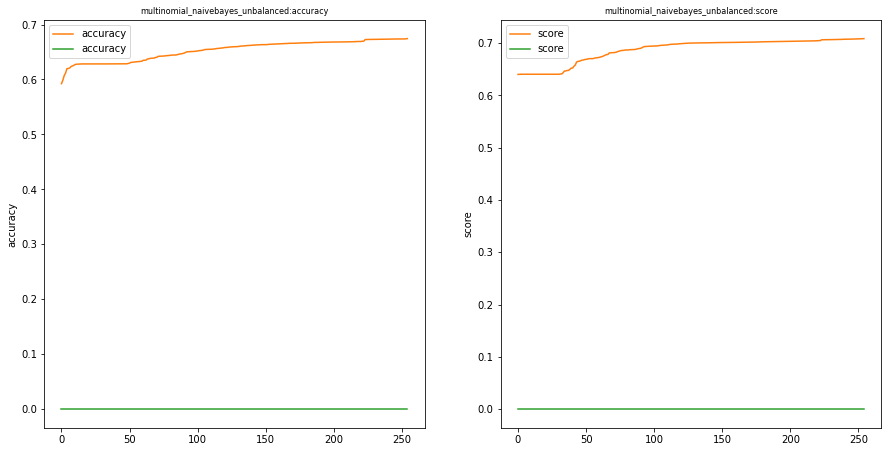

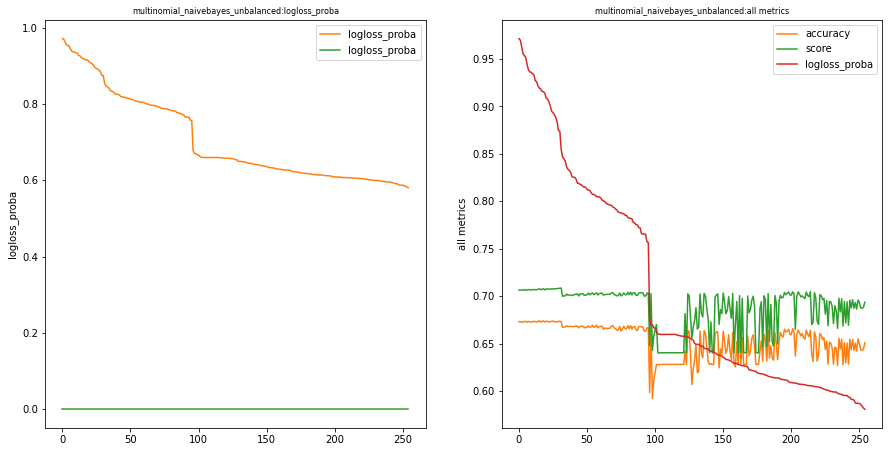

In [122]:
def show_all_metric_all_models(results,y_label,metric_sort,metrics):
    palette = sns.color_palette()
    data = results.sort_values(metric_sort+'_test',ascending=(metric_sort!='logloss_proba'))
    #ax = plot
    # fig,ax = plot.subplots()
    x = numpy.arange(len(data))
    num_col=1
    if len(metrics)>1:
        kinds =['_test']
    else:
        kinds = ['_test','_full']
    for k in kinds:
        for m in metrics:
                plot.plot(x,data[m+k],color = palette[num_col],label = m)
                num_col = num_col+1
    plot.ylabel(y_label)
    #plot.plot(x,nb_features,color = palette[num_col],label='Nb features')
    plot.title(EXPERIMENT+':'+ y_label,fontsize=8)
    #plot.xticks(x)
    #ax.set_xticklabels(labels)
    plot.legend()


def show_all_metrics_all_models(results):
    for m in ['accuracy','score','logloss_proba']:
        yield
        show_all_metric_all_models(model_results,m,m,[m])
    yield
    show_all_metric_all_models(model_results,'all metrics','logloss_proba',['accuracy','score','logloss_proba'])

#show_all_metrics_all_models(model_results)
def show_all_metrics_all_models_in_grid(results,nb_columns=2):
    multiplot_from_generator(show_all_metrics_all_models(results), nb_columns)

show_all_metrics_all_models_in_grid(model_results)


In [117]:

model_results

,accuracy_test,score_test,logloss_classif_test,logloss_proba_test,accuracy_full,score_full,logloss_classif_full,logloss_proba_full
nb_words_question1,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
nb_words_question2,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
nb_common_words,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
nb_common_words/nb_words_question1,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
nb_common_words/nb_words_question2,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
...,...,...,...,...,...,...,...,...
nb_words_question1+nb_words_question2+nb_common_words+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.673440,0.707098,11.279131,0.938410,0.673536,0.707563,11.275799,0.936413
nb_words_question1+nb_words_question2+nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.665055,0.702758,11.568728,0.670387,0.666163,0.703846,11.530456,0.668555
nb_words_question1+nb_common_words+nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.673378,0.706629,11.281269,0.969826,0.673190,0.706720,11.287762,0.967807
nb_words_question2+nb_common_words+nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.672599,0.706541,11.308177,0.962883,0.672589,0.706776,11.308519,0.961521


Some code for an easy apply (display kaggle command for subscription)

In [14]:
# Suppose global variable all_models_dict is available !

# kind is 'test or 'full'
def retrieve_model(model_key,kind):
    combination_results = all_models_dict[model_key]
    column_names = combination_results['column_names']
    model = combination_results['model_'+kind]
    return model,numpy.asarray(column_names)
    
# return a dataframe fully ready to be converted in csv and published into kaggle
def simple_apply(model_key,input_dataframe,kind,proba=True):
    model,column_names=retrieve_model(model_key,kind)
    input_for_prediction=input_dataframe[column_names]
    res = pandas.DataFrame()
    if 'test_id' in input_dataframe.columns:
        res['test_id']=input_dataframe['test_id']
    if proba:
        res['is_duplicate']=pandas.Series(model.predict_proba(input_for_prediction)[:,1],name='is_duplicate')
    else:
        res['is_duplicate']=pandas.Series(model.predict(input_for_prediction),name='is_duplicate')
    return res


def show_docker_cp_command(absolute_file_name):
    return 'docker cp '+ DOCKER_IMAGE_NAME+':'+zip_file_name(absolute_file_name)+ ' c:\\temp\\outputs'

def show_kaggle_command(absolute_file_name):
    return 'kaggle competitions submit quora-question-pairs -f "' + zip_file_name(absolute_file_name) +'" -m "' + absolute_file_name +'"'

def show_docker_cp_commands(best_results):
    print_section('Use these commands to transfer apply results to windows host')
    for c in best_results['file_name'].apply(show_docker_cp_command):
        print_warning(c)
    print_done("")

def show_kaggle_commands(best_results):
    print_section('Use these commands to submit apply results to kaggle')
    for c in best_results['file_name'].apply(show_kaggle_command):
        print_warning(c)
    print_done("")
   

def submit_model(criteria,kind,input_dataframe,model_key,proba=True,show_how_to_publish=True,kaggle=False):
    absolute_file_name_csv = apply_absolute_file_name(criteria,kind,model_key)
    print_info('Doing apply')
    prediction = simple_apply(model_key,input_dataframe,kind,proba)
    print_info('Generating CSV file')
    prediction.to_csv(absolute_file_name_csv,index=False)
    print_info('Zipping file')
    absolute_file_name_zip = zip_file_and_delete(absolute_file_name_csv)
    print_info('%s is ready' % absolute_file_name_csv)
    if show_how_to_publish:
        if kaggle:
            print_warning('Use this commands to submit apply results to kaggle')
            print_warning(show_kaggle_command(absolute_file_name_zip))
        else:
            print_warning('Use this command to transfer apply _results to Windows host')
            print_warning(show_docker_cp_command(absolute_file_name_csv))

# suppose global variable model_results is available
def find_best_models(top,criteria,kind):
    if 'logloss' in criteria:
        return model_results.nsmallest(top,criteria+'_'+kind)
    else:
        return model_results.nlargest(top,criteria+'_'+kind)

def submit_best_models(top,criteria,kind,input_dataframe,proba=True,kaggle=False):
    print_section('Submit best %d %s models by %s' % (top,kind,criteria))
    best_models = find_best_models(top,criteria,kind)
    best_models['model_key']=numpy.asarray(best_models.index)
    #best_models['file_name']=numpy.array([apply_file_name(criteria,kind,n) for n in best_models.index])
    best_models['file_name']=best_models['model_key'].apply(lambda mk: apply_absolute_file_name(criteria,kind,mk))
    best_models['model_key'].apply(lambda mk: submit_model(criteria,kind,input_dataframe,mk,proba=proba,show_how_to_publish=False,kaggle=kaggle))
    best_models['docker']=best_models['file_name'].apply(show_docker_cp_command)
    best_models['kaggle']=best_models['file_name'].apply(show_kaggle_command)
    print_done('Done')
    if kaggle:
        show_kaggle_commands(best_models)
    else:
        show_docker_cp_commands(best_models)
    return best_models

# What are the best 4 full models ?

In [15]:
#retrieve_model('nb_common_words+nb_common_words/(nb_words_question1+nb_words_question2)','full')
#simple_apply('nb_common_words+nb_common_words/(nb_words_question1+nb_words_question2)',challenge_dataframe,'full')
find_best_models(4,'logloss_proba','full')
#submit_best_models('accuracy','full',train_dataframe)
#submit_best_models('score','full',challenge_dataframe)
# best_accuracy_full_models = submit_best_models(3,'accuracy','full',challenge_dataframe)
# show_docker_cp_commands(best_accuracy_full_models)


,accuracy_test,score_test,logloss_classif_test,logloss_proba_test,accuracy_full,score_full,logloss_classif_full,logloss_proba_full
nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words,0.650968,0.693784,12.055234,0.581016,0.652786,0.695453,11.992442,0.579412
nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.644339,0.688499,12.284168,0.582293,0.645203,0.689231,12.254354,0.580778
nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.643251,0.687594,12.321761,0.584173,0.644822,0.688958,12.267513,0.582438
nb_common_words/nb_words_question1+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.643375,0.687585,12.317485,0.586088,0.644045,0.688145,12.294334,0.584323


## What are the best 4 test models ?

In [37]:
find_best_models(4,'logloss_proba','test')

,accuracy_test,score_test,logloss_classif_test,logloss_proba_test,accuracy_full,score_full,logloss_classif_full,logloss_proba_full
nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words,0.650968,0.693784,12.055234,0.581016,0.652786,0.695453,11.992442,0.579412
nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.644339,0.688499,12.284168,0.582293,0.645203,0.689231,12.254354,0.580778
nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.643251,0.687594,12.321761,0.584173,0.644822,0.688958,12.267513,0.582438
nb_common_words/nb_words_question1+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.643375,0.687585,12.317485,0.586088,0.644045,0.688145,12.294334,0.584323


## Find the best models for all metrics (deactivated)

In [36]:
#print('%d models have been trained' %len(all_models_dict))
#print('\nmax metrix\n',model_results.idxmax())
#print('\nmin metrix\n',model_results.idxmin())

## Apply full models with best logloss 


In [17]:
#best_accuracy_full_models = submit_best_models(3,'accuracy','full',challenge_dataframe)
#show_docker_cp_commands(best_accuracy_full_models)
#best_score_full_models = submit_best_models(3,'score','full',challenge_dataframe)
#show_docker_cp_commands(best_score_full_models)
#best_accuracy_test_models = submit_best_models(3,'accuracy','test',challenge_dataframe)
#show_docker_cp_commands(best_accuracy_test_models)
#best_score_test_models = submit_best_models(3,'score','test',challenge_dataframe)
#show_docker_cp_commands(best_score_test_models)
best_logloss_proba_test = submit_best_models(3,'logloss_proba','test',challenge_dataframe,kaggle=True)


## Apply full models with best logloss

In [ ]:
best_logloss_proba_full = submit_best_models(3,'logloss_proba','full',challenge_dataframe,kaggle=True)

## Redisplay again the commands to submit to kaggle

In [38]:
#show_docker_cp_commands(best_logloss_proba_full)
show_kaggle_commands(best_logloss_proba_full)
show_kaggle_commands(best_logloss_proba_test)

## Manual submission (deactivated)

In [ ]:
# submit_model('score','full',challenge_dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)',kaggle=True)

## Submit best models on all metrics (deactivated)

In [ ]:

def submit_all_bests(criterias,input_dataframe,kaggle=False):
    kinds = ['full','test']
    print_section('Submit best models by %sx%s' % (criterias,kinds))
    all_file_names = list()
    for c in tqdm(criterias):
        for k in kinds:
            print_info('Best %s_%s' %(c,k))
            best_model = find_best_models(1,c,k)
            generated_file = apply_absolute_file_name(c,k,best_model.index)
            best_model['model_key']=numpy.asarray(best_model.index)
            best_model['model_key'].apply(lambda mk: submit_model(c,k,input_dataframe,mk,proba=True,show_how_to_publish=False,kaggle=kaggle))
            all_file_names.append(generated_file)
    print_done('Done')
    commands = pandas.DataFrame()
    commands['file_name']=all_file_names
    if kaggle:
        commands['kaggle'] = commands['file_name'].apply(show_kaggle_command)
        show_kaggle_commands(commands)
    else:
        commands['docker'] = commands['file_name'].apply(show_docker_cp_command)
        show_docker_cp_commands(commands)
    return commands

# submit_all_bests(['accuracy','score','logloss_classif','logloss_proba'],challenge_dataframe,kaggle=True)


## Display training performnces of all models

In [39]:
model_results

,accuracy_test,score_test,logloss_classif_test,logloss_proba_test,accuracy_full,score_full,logloss_classif_full,logloss_proba_full
nb_words_question1,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
nb_words_question2,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
nb_common_words,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
nb_common_words/nb_words_question1,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
nb_common_words/nb_words_question2,0.628299,0.640531,12.838098,0.659876,0.630802,0.642096,12.751642,0.658527
...,...,...,...,...,...,...,...,...
nb_words_question1+nb_words_question2+nb_common_words+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.673440,0.707098,11.279131,0.938410,0.673536,0.707563,11.275799,0.936413
nb_words_question1+nb_words_question2+nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.665055,0.702758,11.568728,0.670387,0.666163,0.703846,11.530456,0.668555
nb_words_question1+nb_common_words+nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.673378,0.706629,11.281269,0.969826,0.673190,0.706720,11.287762,0.967807
nb_words_question2+nb_common_words+nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.672599,0.706541,11.308177,0.962883,0.672589,0.706776,11.308519,0.961521


## Save training performances of all models on a convenenien Excel file

In [18]:

save_models_dict_to_excel(all_models_dict)

## Load our kaggle scores

In [19]:
all_submissions = load_kaggle_submissions()


In [27]:
show_last_submissions(all_submissions)
#show_best_submissions(all_submissions,metric='publicScore')

,date,publicScore,privateScore,description,fileName
0,2020-09-10 21:24:17,0.49314,0.49464,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!test!nb_common_words_div_nb_words_question2+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probatestnb_common_words_div_nb_words_question2nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...
1,2020-09-10 21:24:02,0.49074,0.49211,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!test!nb_common_words_div_nb_words_question1+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probatestnb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...
2,2020-09-10 21:23:42,0.49432,0.49583,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!test!nb_common_words_div_nb_words_question1+nb_common_words_div_nb_words_question2+nb_words...,multinomial_naivebayes_unbalancedlogloss_probatestnb_common_words_div_nb_words_question1nb_common_words_div_nb_words_question2nb_words_question1-common_wordsnb_words_question2-common_words.zip


In [29]:
show_best_submissions(all_submissions,metric='privateScore')


,privateScore,date,publicScore,description,fileName
15,0.35579,2020-09-08 21:51:27,0.35408,first xgboost,simple_xgb.csv
1,0.49211,2020-09-10 21:24:02,0.49074,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!test!nb_common_words_div_nb_words_question1+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probatestnb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...
4,0.49246,2020-09-10 21:22:42,0.49109,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!full!nb_common_words_div_nb_words_question1+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probafullnb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...


In [34]:
show_best_submissions(all_submissions,metric='publicScore',n=5)

,publicScore,date,privateScore,description,fileName
15,0.35408,2020-09-08 21:51:27,0.35579,first xgboost,simple_xgb.csv
1,0.49074,2020-09-10 21:24:02,0.49211,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!test!nb_common_words_div_nb_words_question1+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probatestnb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...
4,0.49109,2020-09-10 21:22:42,0.49246,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!full!nb_common_words_div_nb_words_question1+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probafullnb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...
0,0.49314,2020-09-10 21:24:17,0.49464,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!test!nb_common_words_div_nb_words_question2+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probatestnb_common_words_div_nb_words_question2nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...
3,0.49341,2020-09-10 21:23:05,0.49490,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!full!nb_common_words_div_nb_words_question2+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probafullnb_common_words_div_nb_words_question2nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...


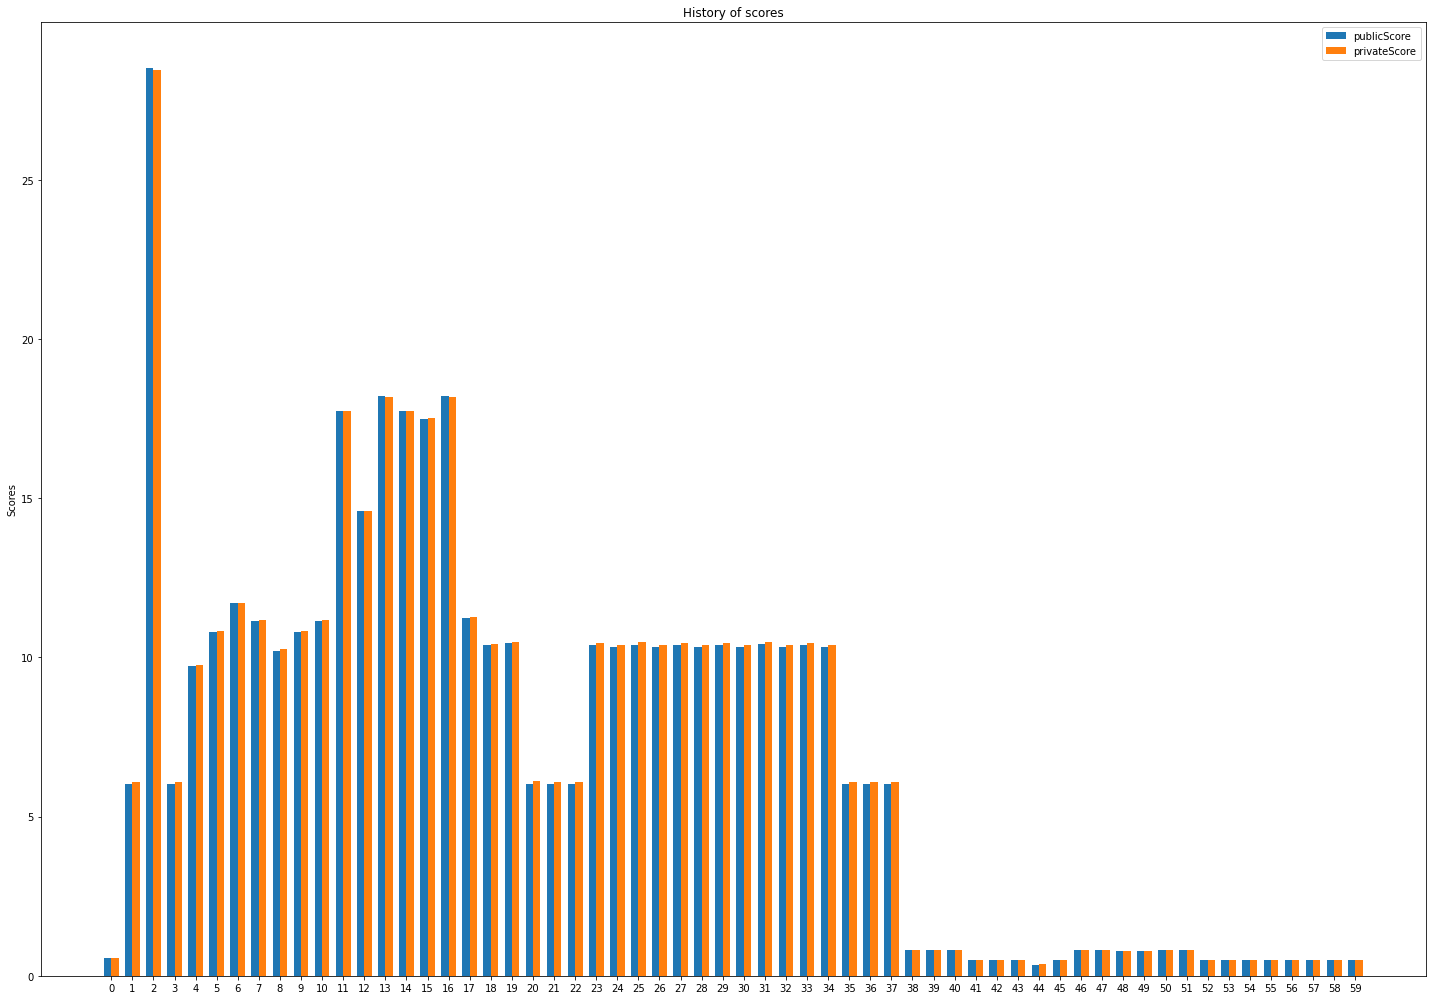

In [30]:
def display_submissions(dataframe):
    print_section( 'Show history of submissions')
    for name in ['publicScore']: #all_numeric_columns(dataframe):
        yield
        display_submission(dataframe)
    print_done('Done')

def display_submissions_in_grid(dataframe,nb_columns=2):
    multiplot_from_generator(display_submissions(dataframe), nb_columns)

def auto_label(rects):
    for rect in rects:
        height = rect.get_height()
        plot.annotate('{}'.format(height),xy=(rect.get_x()+rect.get_width()/2,height),xytext=(0,3),textcoords='offset points',ha='center',va='bottom')


# Only useful to show private/public is almost the same
# at least now
def display_submission_private_public(dataframe):
    #dataframe = dataframe[dataframe['publicScore']>0.4][dataframe['publicScore']<1]
    dataframe = dataframe.sort_values('date')
    labels = dataframe['description']
    public_scores = dataframe['publicScore']
    private_scores = dataframe['privateScore']
    x = numpy.arange(len(labels))
    width = 0.35
    fig = plot.figure(figsize=(20, 14))
    #ax = plot
    # fig,ax = plot.subplots()
    rects_public_score = plot.bar(x-width/2,public_scores,width,label = 'publicScore')
    rects_private_score = plot.bar(x+width/2,private_scores,width,label = 'privateScore')
    plot.ylabel('Scores')
    plot.title('History of scores')
    plot.xticks(x)
    #ax.set_xticklabels(labels)
    plot.legend()
    #auto_label(rects_public_score)
    fig.tight_layout()
    plot.show()

def find_description_test_and_full(dataframe):
    list_test = list()
    list_full = list()
    for i,d in dataframe.iterrows():
        #print(d)
        if d.description.find('!test!')>=0:
            list_test.append(d.description.replace('!test!','!x!'))
        if d.description.find('!full!')>=0:
            list_full.append(d.description.replace('!full!','!x!'))
    list_test_and_full = list(set(list_test)&set(list_full))
    list_test = [i.replace('!x!','test') for i in list_test_and_full]
    list_full = [i.replace('!x!','full') for i in list_test_and_full]
    return [i.replace('!x!','!test!') for i in list_test_and_full]+[i.replace('!x!','!full!') for i in list_test_and_full]
    
        

def display_submission_full_test_public(dataframe):
    #dataframe = dataframe[dataframe['publicScore']>0.4][dataframe['publicScore']<1]
    dataframe = dataframe.sort_values('date')
    test_and_full = find_description_test_and_full(dataframe)
    test_and_full_scores = dataframe[dataframe['description'].isin(test_and_full)]
    test_scores = test_and_full_scores[test_and_full_scores['description'].str.find('!test!')>=0]['publicScore']
    full_scores = test_and_full_scores[test_and_full_scores['description'].str.find('!full!')>=0]['publicScore']
    width = 0.35
    fig = plot.figure(figsize=(15, 10))
    #ax = plot
    # fig,ax = plot.subplots()
    x = numpy.arange(len(test_scores))
    rects_test_score = plot.bar(x-width/2,test_scores,width,label = 'Score on test')
    x = numpy.arange(len(full_scores))
    rects_full_score = plot.bar(x+width/2,full_scores,width,label = 'Score on full')
    plot.ylabel('Scores')
    plot.title('History of scores')
    plot.xticks(x)
    #ax.set_xticklabels(labels)
    plot.legend()
    #auto_label(rects_public_score)
    fig.tight_layout()
    plot.show()



#all_submissions['description']
res = find_description_test_and_full(all_submissions)
display_submission_private_public(all_submissions)
#display_submission_private_public(all_submissions)
